# Documents Similarity

### Read Files

In [1]:
path_name_documents = './Databases/prova/prova.jsonl'
#path_name_documents = './Databases/prova/prova2.jsonl'
#path_name_documents = './Databases/prova/prova4.jsonl'
#path_name_documents = './Databases/prova/prova10.jsonl'
#path_name_documents = './Databases/prova/prova50.jsonl'  
#path_name_documents = './Databases/prova/prova5000.jsonl'
#path_name_documents = './Databases/prova/prova2000.jsonl'
#path_name_documents = './Databases/prova/prova30000.jsonl'

In [2]:
import json
import numpy as np
import string

def readFile(path_name):
    # Load the JSONL file into a list
    with open(path_name, 'r') as f:
        lines = f.readlines()

    # Convert each JSON object into a dictionary
    dicts = [json.loads(line) for line in lines]

    # Convert the dictionaries into arrays and stack them vertically
    arrays = np.vstack([np.array(list(d.values())) for d in dicts])

    # Convert the arrays into a list of lists
    text = arrays.tolist()
    
    return text

documents = readFile(path_name_documents)

In [3]:
import time

def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time: {end_time - start_time:.5f} seconds")
        return result
    return wrapper

## Tokenized

In [4]:
import json
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


stop_words = set(stopwords.words('english'))

def stemmingLemming(filtered_tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Perform stemming or lemmatization on filtered tokens
    
    filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return filtered_tokens
    
 
    

def tokenize(path_name):
    
    with open(path_name, "r") as f:
        data = f.readlines()

        # Create an empty list to store the tokenized documents
        tokenized_docs = []

        # Loop through each line in the JSONL file
        for line in data:
            # Parse the JSON string into a Python dictionary
            doc = json.loads(line)

            # Extract the text from the dictionary
            text = doc['text']
            text = text.lower()  # Convert to lowercase
            #text = re.sub(r'\d+', '', text)  # Remove all numbers
            text = text.translate(str.maketrans('', '', string.punctuation))  # Remove all punctuation

            # Tokenize the text using NLTK
            tokens = word_tokenize(text)
            tokensStemLem = stemmingLemming(tokens)

            # Add the tokenized document to the list
            tokenized_docs.append(tokensStemLem)

        # Print the tokenized documents
    return tokenized_docs


tokenized_docs = tokenize(path_name_documents)


## Sparse Vectors

### TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer


def calculateTFIDF(tokenized_docs):  
    vectorizer = TfidfVectorizer()
    # Fit and transform the tokenized documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([' '.join(doc) for doc in tokenized_docs])

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Return the TF-IDF matrix and the feature names
    return tfidf_matrix, feature_names,vectorizer
       
tfidf_matrix_docs, feature_names_docs,vectorizer  = calculateTFIDF(tokenized_docs)

## Cosine Similarity

In [6]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def similarity(tfidf_matrix):
    # we compute the cosine similarity between the documents
    cos_sim = cosine_similarity(tfidf_matrix)

    # we create a table with the similarity cosines for each pair of documents
    sim_table = pd.DataFrame(cos_sim, columns=['Doc ' + str(i+1) for i in range(cos_sim.shape[0])], index=['Doc ' + str(i+1) for i in range(cos_sim.shape[0])])
    
    return sim_table, cos_sim

cos_sim_table, cos_sim = similarity(tfidf_matrix_docs)
cos_sim_table

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5
Doc 1,1.000000,0.483146,0.323318,0.323318,0.0
Doc 2,0.483146,1.000000,0.000000,0.000000,0.0
Doc 3,0.323318,0.000000,1.000000,1.000000,0.0
Doc 4,0.323318,0.000000,1.000000,1.000000,0.0
Doc 5,0.000000,0.000000,0.000000,0.000000,1.0


### Set the threshold value

In [7]:
threshold = 0.1

# Sequential Algorithms

### For each document create pairs of similar documents

In [8]:
def sequential_pair_similar_documents(cos_sim, threshold):   
    # We create a list of pairs of similar documents with a similarity value greater than the threshold
    sim_pairs = []
    n_docs = cos_sim.shape[0]
    for i in range(n_docs):
        for j in range(i+1, n_docs):
            if cos_sim[i,j] > threshold:
                sim_pairs.append((i+1, j+1))
            
    return sim_pairs



### Best execution time

In [9]:
import time

def sequential_pair_similar_documents(cos_sim, threshold):
    start_time = time.time()
    # Find the indexes of cells that exceed the similarity threshold
    sim_idxs = np.argwhere(cos_sim > threshold)
    # Converts cell indexes to similar document pairs
    sim_pairs = [(i+1, j+1) for i, j in sim_idxs if i < j]
    
    end_time = time.time()
    sequential_total_time = end_time - start_time

    return sim_pairs, sequential_total_time


sim_pairs , sequential_total_time = sequential_pair_similar_documents(cos_sim, threshold)

    

In [10]:
sim_pairs

[(1, 2), (1, 3), (1, 4), (3, 4)]

In [11]:
sequential_total_time

0.0

In [12]:
num_pairs_sequential = len(sim_pairs)
num_pairs_sequential

4

### For each document calculate the number of similar documents

In [13]:
def sequential_count_similar_documents(cos_sim, threshold):
    num_similar = []
    n_docs = cos_sim.shape[0]
    for i in range(n_docs):
        num = 0
        for j in range(i+1, n_docs):
            if cos_sim[i,j] > threshold:
                num += 1
        num_similar.append(num)
    return num_similar, threshold

num_similar, threshold = sequential_count_similar_documents(cos_sim, threshold)


### For each document create a list with similar documents

In [14]:
def sequential_similar_documents(cos_sim, threshold):
    similar_docs = []
    n_docs = cos_sim.shape[0]
    for i in range(n_docs):
        sim_docs = []
        for j in range(i+1, n_docs):
            if cos_sim[i,j] > threshold:
                sim_docs.append(f"Doc {j+1}")
        similar_docs.append(sim_docs)
    return similar_docs

similar_docs = sequential_similar_documents(cos_sim, threshold)


### Table of final results

In [15]:
def create_similar_table(similar_docs, num_similar, threshold):
    doc_names = [f"Doc {i+1}" for i in range(len(num_similar))]
    similar_docs_str = [", ".join(docs) for docs in similar_docs]
    similar_table = pd.DataFrame({"Documents": doc_names, "Number of similar documents": num_similar, "Similar Documents": similar_docs_str, "Threshold": threshold})
    pd.set_option('display.max_rows', None)

    return similar_table

similar_table = create_similar_table(similar_docs, num_similar, threshold)
similar_table

,Documents,Number of similar documents,Similar Documents,Threshold
0,Doc 1,3,"Doc 2, Doc 3, Doc 4",0.1
1,Doc 2,0,,0.1
2,Doc 3,1,Doc 4,0.1
3,Doc 4,0,,0.1
4,Doc 5,0,,0.1


# Parallel Algorithm

### Function to take input data

In [16]:
from scipy.sparse import coo_matrix

def extract_document_terms(tfidf_matrix):
    matrix_coo = coo_matrix(tfidf_matrix)
    data = matrix_coo.data
    row = matrix_coo.row
    col = matrix_coo.col

    doc_terms = []
    current_doc = -1
    terms = []

    for i in range(len(data)):
        doc_id = row[i]
        term_id = col[i]
        term_value = data[i]

        if doc_id != current_doc:
            if terms:
                doc_terms.append((current_doc+1, terms))
                terms = []
            current_doc = doc_id

        terms.append((term_id, term_value))

    if terms:
        doc_terms.append((current_doc, terms))

    return doc_terms

doc_info_list = extract_document_terms(tfidf_matrix_docs)
#print(doc_info_list)


## Functions Map and Reduce

In [17]:
def my_map(doc_info):
    mapped_doc = []

    doc_id, terms = doc_info
    
    max_term_id = max(terms, key=lambda x: x[0])[0]
    doc_terms = [(term_id, value) for term_id, value in terms]
    mapped_doc.append((doc_id, max_term_id, doc_terms))

    return mapped_doc



In [18]:
def my_reduce(docs, threshold):
    pairs = []
    docs_list = list(docs)  # Convert the docs iterator to a list

    n_docs = len(docs_list)
    print(n_docs)
    
    for i in range(n_docs - 1):
        for j in range(i + 1, n_docs):
            doc1_id, term_id, doc1 = docs_list[i]
            doc2_id, _, doc2 = docs_list[j]

            terms_1 = {t_id1: val1 for t_id1, val1 in doc1}
            terms_2 = {t_id2: val2 for t_id2, val2 in doc2}

            common_terms = set(terms_1).intersection(terms_2)

            if not common_terms:
                continue

            max_term = max(common_terms)

            sim = 0.0

            for term in common_terms:
                sim += terms_1[term] * terms_2[term]

            if sim >= threshold:
                if doc2_id == n_docs:
                    doc2_id += 1
                pair = ((doc1_id, doc2_id), sim)
                pairs.append(pair)

    return pairs




# Implementazioni per Spark 

In [19]:
import os
os.environ['PYSPARK_PYTHON'] = 'C:/Users/lita4/anaconda3/python.exe'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'C:/Users/lita4/anaconda3/python.exe'

### Execution with spark

#### Input Data

In [20]:
doc_info_list = extract_document_terms(tfidf_matrix_docs)


In [23]:
from pyspark import SparkConf, SparkContext
import time

total_results_time = []
num_pairs_parallel = 0


for i in range(1,9):

    print("EXECUTION WITH PARTITIONS = ",i)
    start_time = time.time()
    conf = SparkConf().setAppName("MyApp").setMaster("local[16]").set("spark.executor.memory", "20g").set("spark.network.timeout", "600s")
    sc = SparkContext(conf=conf)


    print("EXECUTION INPUT")
    input_rdd = sc.parallelize(doc_info_list,i)
    print(input_rdd.collect())

    print("EXECUTION MAP")
    mapped_rdd = input_rdd.flatMap(my_map)
    #print(mapped_rdd.collect())

    print("EXECUTION REPARTITION")
    mapped_rdd = mapped_rdd.repartition(i)
    # Repartition the RDD to evenly distribute the data across partitions


    print("EXECUTION REDUCE")
    reduced_pairs = mapped_rdd.mapPartitions(lambda docs: my_reduce(docs, threshold))
    print("EXECUTION RESULTS")
    results = reduced_pairs.collect()

    end_time = time.time()
    total_time = end_time - start_time

    print("Time of execution",total_time)
    total_results_time.append(total_time)

    results = list(set(results))
    for result in sorted(results):
        print(result)

    print()

    if(i == 1):
        num_pairs_parallel = len(results)

    sc.stop()

EXECUTION WITH PARTITIONS =  1
EXECUTION INPUT
[(1, [(6, 0.7694470729725092), (5, 0.6387105775654869)]), (2, [(2, 0.7782829228046183), (6, 0.6279137616509933)]), (3, [(1, 0.6098184563533858), (7, 0.6098184563533858), (5, 0.5062044059286201)]), (4, [(1, 0.6098184563533858), (7, 0.6098184563533858), (5, 0.5062044059286201)]), (4, [(4, 0.5773502691896258), (0, 0.5773502691896258), (3, 0.5773502691896258)])]
EXECUTION MAP
EXECUTION REPARTITION
EXECUTION REDUCE
EXECUTION RESULTS
Time of execution 1.6409978866577148
((1, 2), 0.48314640598151465)
((1, 3), 0.32331810847686315)
((1, 4), 0.32331810847686315)
((3, 4), 1.0)

EXECUTION WITH PARTITIONS =  2
EXECUTION INPUT
[(1, [(6, 0.7694470729725092), (5, 0.6387105775654869)]), (2, [(2, 0.7782829228046183), (6, 0.6279137616509933)]), (3, [(1, 0.6098184563533858), (7, 0.6098184563533858), (5, 0.5062044059286201)]), (4, [(1, 0.6098184563533858), (7, 0.6098184563533858), (5, 0.5062044059286201)]), (4, [(4, 0.5773502691896258), (0, 0.5773502691896258)

In [24]:
num_pairs_parallel

4

In [25]:
total_results_time

[1.6409978866577148,
 2.854945421218872,
 4.093005418777466,
 5.298999309539795,
 6.599201440811157,
 7.76200008392334,
 9.115000486373901,
 10.306762933731079]

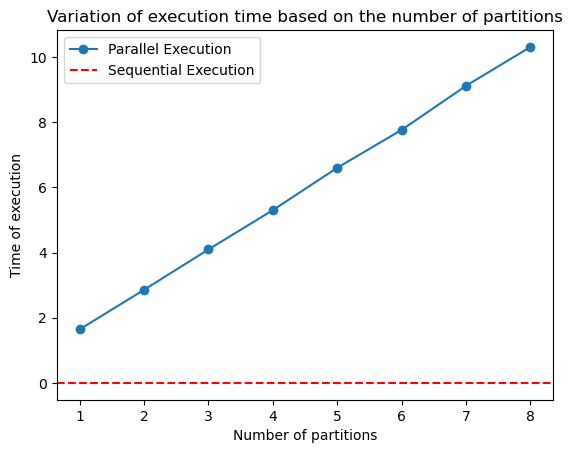

In [26]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def generate_plot(total_results_time, sequential_total_time):
    num_partitions = range(1, len(total_results_time) + 1)

    # Creazione del grafico
    plt.plot(num_partitions, total_results_time, marker='o', label='Parallel Execution')
    plt.axhline(y=sequential_total_time, color='r', linestyle='--', label='Sequential Execution')

    plt.xlabel('Number of partitions')
    plt.ylabel('Time of execution')
    plt.title('Variation of execution time based on the number of partitions')
    plt.legend()
    plt.show()

               
generate_plot(total_results_time,sequential_total_time)


In [27]:
import matplotlib.pyplot as plt

def generate_bar_chart(counter1, counter2):
    labels = ['Sequential', 'Parallel']
    values = [counter1, counter2]
    colors = ['blue', 'green']  # Esempio di colori diversi per le colonne

    plt.bar(labels, values, color=colors)
    plt.xlabel('Counters')
    plt.ylabel('Values')
    plt.title('Comparison of Counters')
    plt.show()


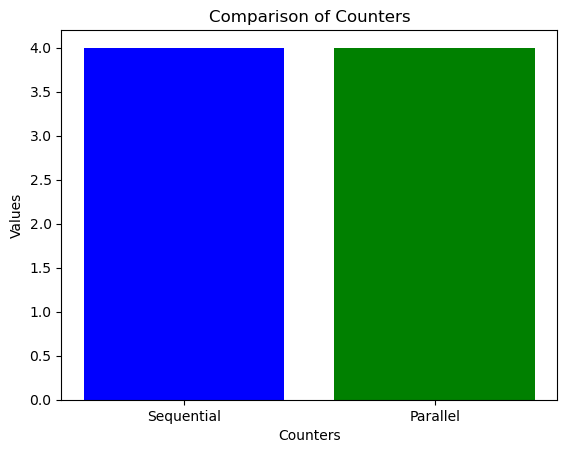

In [28]:
generate_bar_chart(num_pairs_sequential, num_pairs_parallel)